# Práctico 4: Redes convolucionales

En este cuaderno vamos a adentrarnos un poco en uno de los modelos más usados en IA, que tiene una inspiración fuerte en la cognición visual (algo que van a ver en clases siguientes) y vamos a ver cómo procede el entrenamiento y qué descubre la red.

## Configuración

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import ipywidgets as widgets

if torch.cuda.is_available():
  device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
  device = torch.device("mps")
else:
  device = torch.device("cpu")

print("Usando device:", device)

### Funciones utilitarias

In [ ]:
def train_net(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total

@torch.no_grad()
def eval_net(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total

### Funciones de graficado

In [ ]:
def visualizar_activaciones(activations, layer):
  act = activations[layer][0]
  n = act.shape[0]

  cols = int(math.ceil(math.sqrt(n)))
  rows = int(math.ceil(n / cols))

  fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
  axes = axes.flatten()

  for i in range(n):
      axes[i].imshow(act[i], cmap="gray")
      axes[i].axis("off")

  for j in range(n, len(axes)):
      axes[j].axis("off")

  plt.suptitle(f"Activaciones en {layer}")
  plt.show()

def visualizar_barplot(activations, layer):
  act = activations[layer][0].numpy()
  n = len(act)
  plt.figure(figsize=(10,4))
  plt.bar(np.arange(n), act)
  plt.title(f"Activaciones en {layer} ({n} unidades)")
  plt.xlabel("Unidad")
  plt.ylabel("Valor de activación")
  plt.show()

def visualizar_pesos(conv_layer, in_channel=0, max_plots=64):
  W = conv_layer.weight.detach().cpu()  # (out_ch, in_ch, kH, kW)
  n = min(W.shape[0], max_plots)
  cols = int(math.ceil(math.sqrt(n)))
  rows = int(math.ceil(n / cols))
  
  fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
  axes = axes.flatten()
  
  for i in range(n):
      ker = W[i, in_channel].numpy()
      axes[i].imshow(ker, cmap="bwr")  # bwr: azul negativo, rojo positivo
      axes[i].axis("off")
  for j in range(n, len(axes)):
      axes[j].axis("off")
  plt.suptitle(f"Pesos {conv_layer.__class__.__name__}, canal entrada {in_channel}")
  plt.show()


## Dataset: MNIST
Usamos `torchvision.datasets.MNIST` con una transformación mínima (`ToTensor`) que deja las imágenes en rango `[0, 1]` para cargar el con junto MNIST.

In [ ]:

transform = transforms.ToTensor()

train_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

len(train_full), len(test_ds), train_full[0][0].shape

In [ ]:
# Separar un pequeño conjunto para la validación
train_size = int(len(train_full) * 0.9)
val_size = len(train_full) - train_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])

# Instanciar clases utilitarias de PyTorch que nos permiten leer la carpeta data
batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Imprimimos la forma del primer lote
batch = next(iter(train_loader))
batch[0].shape, batch[1].shape

## Nuestra primera red convolucional

Vamos a tratar de resolver este problema usando redes convolucionales.

Primero, tenemos que definir la "arquitectura" de la red:

In [20]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(8 * 7 * 7, 8)
    self.fc2 = nn.Linear(8, 10)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

A continuación, la entrenamos:

In [21]:
# Instanciamos la red
cnn = SimpleCNN().to(device)

# Especificamos el optimizador
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=1e-3)

# Especificamos el criterio para medir la pérdida
criterion = nn.CrossEntropyLoss()

# Reproducibilidad
torch.manual_seed(123)
np.random.seed(123)

# Iteramos sobre una cierta cantidad de épocas
tmax = 5
for ep in range(1, tmax+1):
  # Entrenamos a la red en el conjunto de entrenamiento
  tr_loss, tr_acc = train_net(cnn, train_loader, optimizer_cnn, criterion)

  # Evaluamos en el conjunto de evaluación
  va_loss, va_acc = eval_net(cnn, val_loader, criterion)

  print(f"Época {ep:02d} | Precisión={va_acc:.4f}")

Época 01 | Precisión=0.8957
Época 02 | Precisión=0.9293
Época 03 | Precisión=0.9442
Época 04 | Precisión=0.9515
Época 05 | Precisión=0.9482


Efecutá la celda siguiente para ver las activaciones de las diversas capas de la red ya entrenada. Tené en cuenta que:

- `conv1` es una capa de convolución con una salida de 4 dimensiones y con un kernel de 3x3. Esto produce 4 imagenes un poquito mas chicas que la anterior, de 26x26, ya que la convolucion, si no se le aplica ninguna técnica de *padding*, siempre va a devolver una salida más chica que la entrada.
- `pool1` es una capa de *max pooling* de $2 \times 2$. Esto significa que va a comprimir la imagen a la mitad quedandose sólo con el máximo valor encontrado en cada ventana.
- `conv2` es otra capa de convolución con una salida de 8 dimensiones y con un kernel de 3x3. Esto produce 8 imagenes un poquito mas chicas que la anterior, esta vez de $11 \times 11$.
- `pool2` es otra capa de max pooling de $2 \times 2$. Esto significa que va a comprimir nuevamente la imagen a la mitad quedandose sólo con el máximo valor encontrado en cada ventana.
- `fc1` es una capa de red neuronal densa de 8 nodos conectados a todas las entradas (la salida de `pool2`) y a todas las salidas (`fc2`).
- `fc2` es una capa de red neuronal densa de 10 nodos conectados a todas las entradas (la salida de `pool2`). Codifican la salida esperada.

In [22]:
# Forma en que PyTorch nos permite visualizar las activaciones de las capas ocultas
activations = {}
def make_hook(name):
    def _hook(m, i, o): activations[name] = o.detach().cpu()
    return _hook
hooks = [
    cnn.conv1.register_forward_hook(make_hook('conv1')),
    cnn.pool1.register_forward_hook(make_hook('pool1')),
    cnn.conv2.register_forward_hook(make_hook('conv2')),
    cnn.pool2.register_forward_hook(make_hook('pool2')),
    cnn.fc1.register_forward_hook(make_hook('fc1')),
    cnn.fc2.register_forward_hook(make_hook('fc2')),
]

@widgets.interact(i=(0,len(test_ds)-1, 1), layer=['conv1', 'pool1', 'conv2', 'pool2', 'fc1', 'fc2'])
def visualize(i, layer):
  Xi, Yi = test_ds[i]
  activations.clear()
  _ = cnn(Xi.unsqueeze(0).to(device))
  if layer == 'fc1' or layer == 'fc2':
    visualizar_barplot(activations, layer)
  else:
    visualizar_activaciones(activations, layer)

interactive(children=(IntSlider(value=4999, description='i', max=9999), Dropdown(description='layer', options=…

Efecutá la celda siguiente para ver los pesos de las dos capas de convolución que aprendió la red.

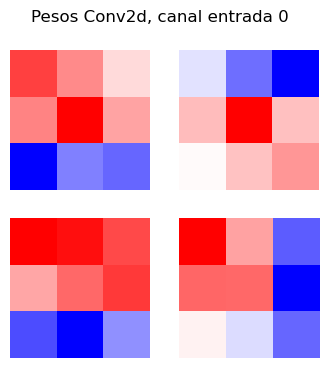

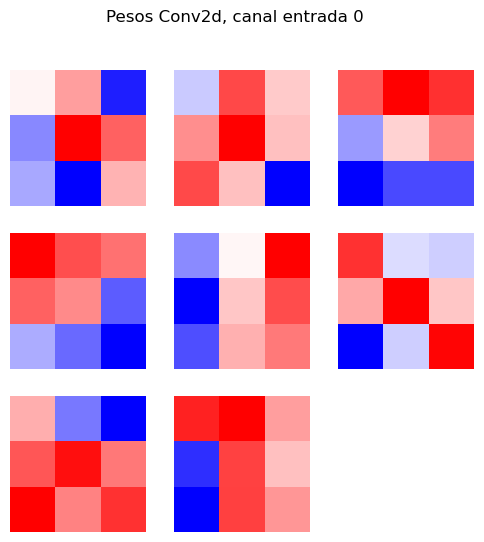

In [23]:
visualizar_pesos(cnn.conv1, in_channel=0)
visualizar_pesos(cnn.conv2, in_channel=0)